# <center> Лабораторная работа №2. Deep Learning. </center>

В данной лабораторной работе предлагается обучить модель на основе нейронной сети для распознавания рукописных букв английского алфавита.

## Данные

Данные представлены двумя датасетами: обучающим (`train`) и тестовым (`test`). Изображения для каждого датасета находятся в `images.zip`.  
  
Обучающая выборка состоит из 65000 изображений - по 2500 изображений для каждой буквы.  
Тестовая выборка состоит из 13000 изображений - по 500 изображений для каждой буквы.  
  
Все изображения - монохромные (но в формате RGB), размерности $28 \times 28$ пикселей, в формате JPEG. 
В названии каждого файла содержатся буква, которая представлена на изображении, и уникальный номер изображения: `a_00002.jpg`.  
  
**NB:** Все изображения представлены в перевернутом виде, для корректного отображения их нужно сначала транспонировать. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pic = plt.imread('images/train/a/a_00011.jpg')
print(pic.shape)

(28, 28, 3)


In [3]:
pic = np.transpose(pic, axes=(1, 0, 2))

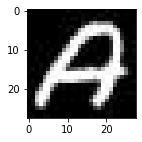

In [4]:
plt.figure(figsize=(2,2))
plt.imshow(pic)
plt.show()

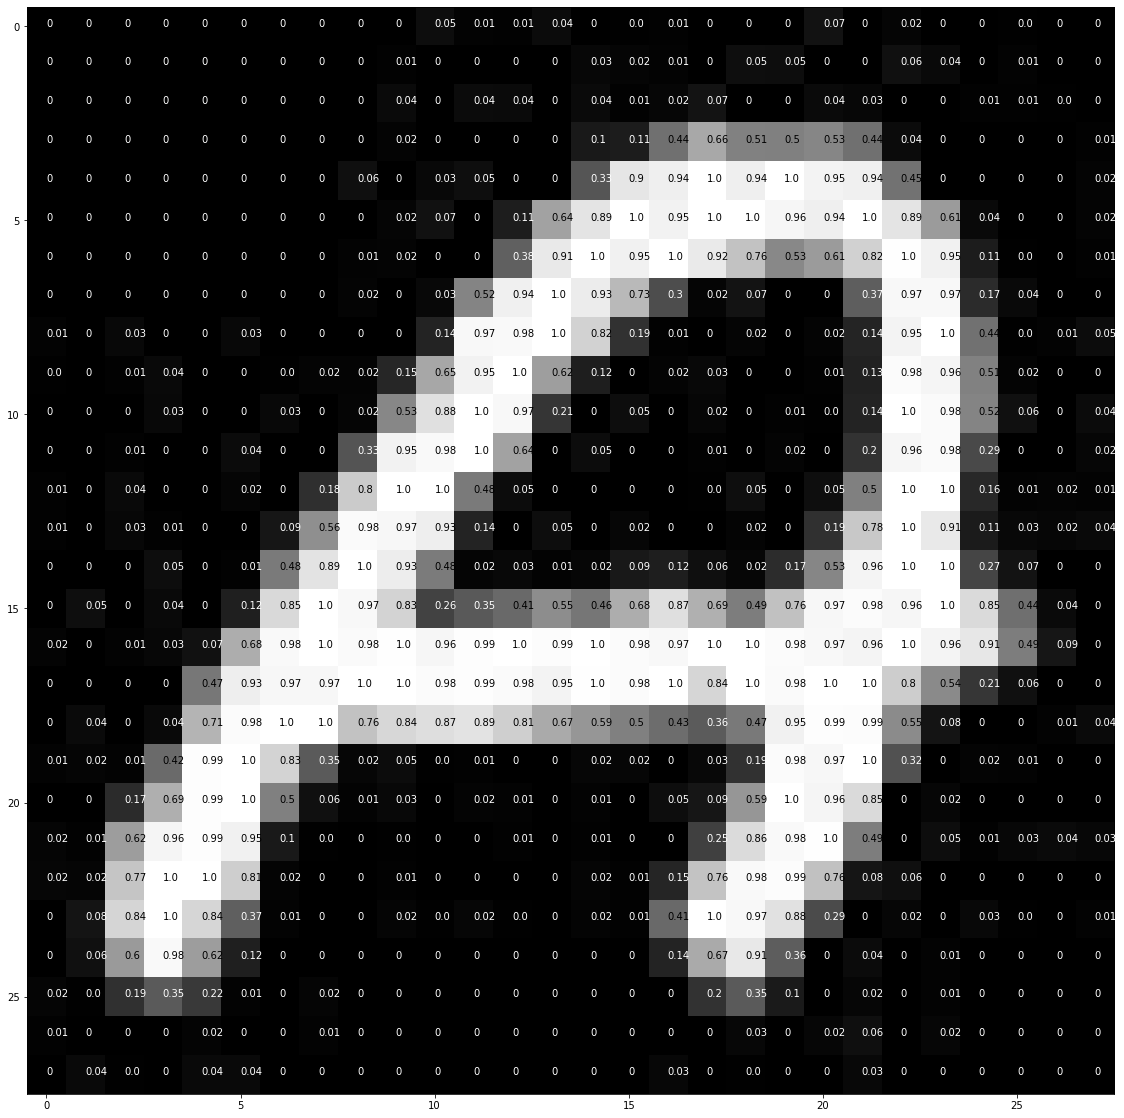

In [5]:
img = np.squeeze(pic)

fig = plt.figure(figsize = (20, 20)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height, _ = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        if img[x][y][2] != 0:
            val = round(img[x][y][2] / 255, 2)
        else:
            val = 0
        ax.annotate(str(val), xy=(y,x),
            color='white' if img[x][y][2] < thresh else 'black')

## Основные задания

Задача - создать и обучить модель на основе нейронной сети, которая будет предсказывать букву на картинке.  
Обучение необходимо проводить на данных из `train`, качество модели проверять на данных из `test`.  
Целевая метрика - accuracy.  
Для моделирования необходимо использовать `pytorch`.

### Задание 1  
  
1. Модель с 2-мя и 3-мя полносвязными (dense) скрытыми слоями.  
Исследуются разные параметры нейронной сети - число нейронов на каждом слое, learning rate, batch size, функции активации, регуляризации и т.д.

In [6]:
# ! pip install torch===1.7.0+cu110 torchvision===0.8.1+cu110 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

In [5]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
# from torchvision import datasets, models
import torchvision.transforms as transforms

import time
import os
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.onnx
import torchvision

from torch.optim.lr_scheduler import StepLR

%matplotlib inline

In [11]:
# import string

# classes = list(string.ascii_lowercase)
# classes

In [4]:
torch.manual_seed(17)

***Определение функций для загрузки данных, их трансформации и обучения нейросети***

In [5]:
# добавление случайных преобразований к картинкам

augm_transf = [torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                  torchvision.transforms.RandomRotation(degrees=45)]

augm = torchvision.transforms.RandomApply(augm_transf, p=0.5)

***В ходе работы тестировалась как работа с применением случайных изменений к данным, так и без них***<br>
***Применение к данным последовательных преобразований без добавления случайных изменений***

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

***Применение к данным последовательных преобразований со случайными изменениями***

In [6]:
data_transforms = {
    'train': transforms.Compose([augm,
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([augm,
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

In [7]:
def get_dataset(data_dir, data_transforms):
    # create train and test datasets
    image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x]) for x in ['train', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    #get classes from train dataset folders name
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes, image_datasets['train']

***Другое значение batch_size***

In [8]:
def get_dataset(data_dir, data_transforms, batch_size):
    # create train and test datasets
    image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x]) for x in ['train', 'test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    #get classes from train dataset folders name
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes, image_datasets['train']

In [7]:
# (next(iter(trainloader))[0].view(next(iter(trainloader))[0].shape[0], -1)).shape

In [9]:
# trainloader, testloader, classes, dataset_sizes, train_dataset = get_dataset('./images', data_transforms)
trainloader, testloader, classes, dataset_sizes, train_dataset = get_dataset('./images', data_transforms, 24)
traindataiter = iter(trainloader)
testdataiter = iter(testloader)

In [9]:
# function to show some random images

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
#     img = np.transpose(pic, axes=(1, 0, 2))
    plt.imshow(np.transpose(npimg, (2, 1, 0)))
    plt.show()

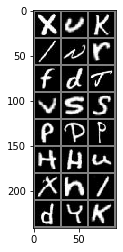

    x     l     f     n     p     h     x     d     u     n     d     s     p     h     h     y     k     r     j     s     p     u     i     k


In [28]:
# get some random training images

images, labels = traindataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(24)))

### Задание 1
***Описание основных функций***

In [10]:
#128
batch_size = 24
use_cuda = torch.cuda.is_available()
print(use_cuda)

torch.manual_seed(17)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))

train_set, val_set = torch.utils.data.random_split(train_dataset, [num_train-split, split])
print(len(train_set), len(val_set))

val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size, shuffle=False, **kwargs)

C:\Users\Tania\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


False
58500 6500


In [11]:
input_size=train_dataset[0][0].shape
num_classes=len(train_dataset.classes)

In [12]:
def train(model, device, train_loader, optimizer, epoch):
    train_loss = 0.0
    total_train = 0
    correct_train = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            display('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()), display_id=str(epoch), update=True)
      
      # accuracy
        _, predicted = torch.max(output.data, 1)
        train_loss += loss.item()
        total_train += target.nelement()  # number of pixel in the batch
        correct_train += predicted.eq(target.data).sum().item() # sum all precited pixel values
  
    epoch_loss = train_loss / len(train_loader.dataset)
    epoch_acc = 100.*(correct_train / total_train)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} {:.0f}%\n'.format(
        epoch_loss,correct_train, total_train, epoch_acc))
    return epoch_loss,epoch_acc

In [13]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy=100. * correct / len(test_loader.dataset)

    print('Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    return test_loss,accuracy

In [14]:
def plot_learning(train_accuracies, val_accuracies):
    epochs = range(1, len(train_accuracies) + 1)

    plt.plot(epochs, train_accuracies, 'r', label='Training acc')
    plt.plot(epochs, val_accuracies, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

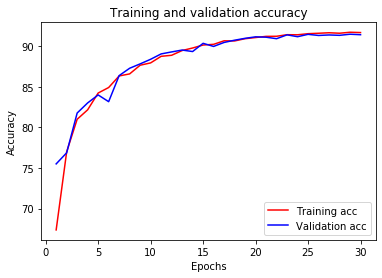

In [41]:
# пример работы функции выше
plot_learning(train_accuracies, val_accuracies)

## Подбор моделей, тестирование параметров

### Тестирование моделей при -/не применении случайных трансформаций и размере batch_size=24

***class Net_2_relu - результат для данных без случайных трансформаций***

In [15]:
class Net_2_relu(nn.Module):
    def __init__(self):
        super(Net_2_relu, self).__init__()
        self.fc1 = nn.Linear(np.prod(input_size), 40)
        self.fc2 = nn.Linear(40, 30)
        self.fc3 = nn.Linear(30, num_classes)
        

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

In [32]:
epochs = 10
device = torch.device("cuda" if use_cuda else "cpu")

model = Net_2_relu().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(model, device, trainloader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

Train set: Average loss: 0.0505, Accuracy: 41408/65000 64%

Val set: Average loss: 0.8842, Accuracy: 4761/6500 (73%)

Train set: Average loss: 0.0347, Accuracy: 48629/65000 75%

Val set: Average loss: 0.7458, Accuracy: 5024/6500 (77%)

Train set: Average loss: 0.0298, Accuracy: 50927/65000 78%

Val set: Average loss: 0.6797, Accuracy: 5160/6500 (79%)

Train set: Average loss: 0.0283, Accuracy: 51479/65000 79%

Val set: Average loss: 0.6344, Accuracy: 5221/6500 (80%)

Train set: Average loss: 0.0259, Accuracy: 52673/65000 81%

Val set: Average loss: 0.6010, Accuracy: 5299/6500 (82%)

Train set: Average loss: 0.0253, Accuracy: 52821/65000 81%

Val set: Average loss: 0.5827, Accuracy: 5349/6500 (82%)

Train set: Average loss: 0.0239, Accuracy: 53568/65000 82%

Val set: Average loss: 0.5541, Accuracy: 5376/6500 (83%)

Train set: Average loss: 0.0235, Accuracy: 53697/65000 83%

Val set: Average loss: 0.5361, Accuracy: 5434/6500 (84%)

Train set: Average loss: 0.0226, Accuracy: 54119/65000 8

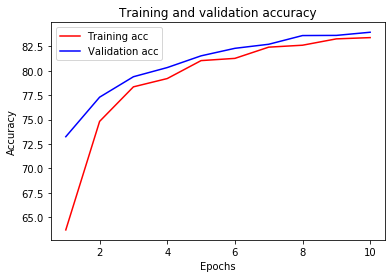

In [33]:
plot_learning(train_accuracies, val_accuracies)

In [34]:
score = test(model, device, testloader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.6004, Accuracy: 10643/13000 (82%)

Test loss: 0.600375837967946
Test accuracy: 81.86923076923077


***Другие значения learning_rate (больший - 0.01) и optimizer - Adagrad***

In [16]:
epochs = 10
device = torch.device("cuda" if use_cuda else "cpu")

model = Net_2_relu().to(device)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(model, device, trainloader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

Train set: Average loss: 0.0525, Accuracy: 40741/65000 63%

Val set: Average loss: 0.9972, Accuracy: 4573/6500 (70%)

Train set: Average loss: 0.0399, Accuracy: 46588/65000 72%

Val set: Average loss: 0.9066, Accuracy: 4806/6500 (74%)

Train set: Average loss: 0.0369, Accuracy: 47995/65000 74%

Val set: Average loss: 0.8666, Accuracy: 4867/6500 (75%)

Train set: Average loss: 0.0355, Accuracy: 48644/65000 75%

Val set: Average loss: 0.8232, Accuracy: 4940/6500 (76%)

Train set: Average loss: 0.0345, Accuracy: 49175/65000 76%

Val set: Average loss: 0.8052, Accuracy: 4966/6500 (76%)

Train set: Average loss: 0.0339, Accuracy: 49426/65000 76%

Val set: Average loss: 0.7905, Accuracy: 5018/6500 (77%)

Train set: Average loss: 0.0334, Accuracy: 49727/65000 77%

Val set: Average loss: 0.7844, Accuracy: 5028/6500 (77%)

Train set: Average loss: 0.0331, Accuracy: 49798/65000 77%

Val set: Average loss: 0.7772, Accuracy: 5054/6500 (78%)

Train set: Average loss: 0.0328, Accuracy: 50020/65000 7

In [17]:
score = test(model, device, testloader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.8152, Accuracy: 9876/13000 (76%)

Test loss: 0.8152254781723023
Test accuracy: 75.96923076923076


***Очевидно, при большем шаге learning_rate и optimizer=Adagrad качество модели несколько ухудшилось***

***class Net_3_tanh - результат для данных со случайными трансформациями***

In [20]:
class Net_3_tanh(nn.Module):
    def __init__(self):
        super(Net_3_tanh, self).__init__()
        self.fc1 = nn.Linear(np.prod(input_size), 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = self.fc4(x)
        output = F.log_softmax(x, dim=1)
        return output

In [21]:
epochs = 10
device = torch.device("cuda" if use_cuda else "cpu")

model = Net_3_tanh().to(device)
optimizer = optim.Adagrad(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(model, device, trainloader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

C:\Users\Tania\Anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train set: Average loss: 0.1330, Accuracy: 20281/65000 31%

Val set: Average loss: 2.4883, Accuracy: 2350/6500 (36%)

Train set: Average loss: 0.1196, Accuracy: 24529/65000 38%

Val set: Average loss: 2.3218, Accuracy: 2553/6500 (39%)

Train set: Average loss: 0.1139, Accuracy: 26674/65000 41%

Val set: Average loss: 2.2418, Accuracy: 2721/6500 (42%)

Train set: Average loss: 0.1105, Accuracy: 27620/65000 42%

Val set: Average loss: 2.1874, Accuracy: 2815/6500 (43%)

Train set: Average loss: 0.1082, Accuracy: 28397/65000 44%

Val set: Average loss: 2.1360, Accuracy: 2884/6500 (44%)

Train set: Average loss: 0.1066, Accuracy: 28932/65000 45%

Val set: Average loss: 2.1076, Accuracy: 2928/6500 (45%)

Train set: Average loss: 0.1051, Accuracy: 29519/65000 45%

Val set: Average loss: 2.0994, Accuracy: 2910/6500 (45%)

Train set: Average loss: 0.1046, Accuracy: 29442/65000 45%

Val set: Average loss: 2.0712, Accuracy: 2988/6500 (46%)

Train set: Average loss: 0.1036, Accuracy: 29761/65000 4

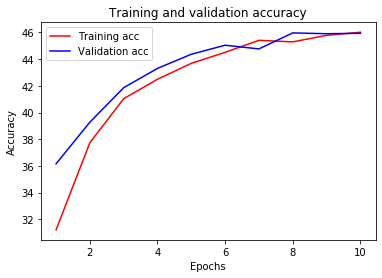

In [22]:
plot_learning(train_accuracies, val_accuracies)

In [23]:
score = test(model, device, testloader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 2.0578, Accuracy: 5976/13000 (46%)

Test loss: 2.057782097156231
Test accuracy: 45.96923076923077


***Очевидно, качество работы модели очень низкое, вероятно, для данного датасета не стоит применять случайные преобразования, в коду ниже без них качество существенно выше***

***Использованные optimizers, под них подбирались параметры learning_rate, weight_decay***

In [ ]:
# criterion = nn.CrossEntropyLoss()
# optimizer_sgd = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer_adam = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-4)
# optimizer_adamax = torch.optim.Adamax(model.parameters(), lr = 0.001, weight_decay=1e-4)
# optimizer_adagrad = torch.optim.Adagrad(model.parameters(), lr = 0.001, weight_decay=1e-4)

### *Ниже приведены классы для создания нейросетей без применения к ним случайных преобразований при размере batch_size = 4 (параметр настраивается выше)*

***Модель с 2 скрытыми полносвязными слоями***<br>
***Функция на выходе - softmax, на промежуточных слоях - ReLU***<br>
***Количество нейронов на скрытых слоях: 40, 30; на выходе - 26 классов, согласно числу букв в алфавите***

In [13]:
class Net_2_relu(nn.Module):
    def __init__(self):
        super(Net_2_relu, self).__init__()
        self.fc1 = nn.Linear(np.prod(input_size), 40)
        self.fc2 = nn.Linear(40, 30)
        self.fc3 = nn.Linear(30, num_classes)
        

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

In [14]:
epochs = 30
device = torch.device("cuda" if use_cuda else "cpu")

model = Net_2_relu().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(model, device, trainloader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

Train set: Average loss: 0.3988, Accuracy: 32818/65000 50%

Val set: Average loss: 1.3587, Accuracy: 3890/6500 (60%)

Train set: Average loss: 0.3327, Accuracy: 38370/65000 59%

Val set: Average loss: 1.2577, Accuracy: 3970/6500 (61%)

Train set: Average loss: 0.3080, Accuracy: 40521/65000 62%

Val set: Average loss: 1.1800, Accuracy: 4144/6500 (64%)

Train set: Average loss: 0.3017, Accuracy: 41052/65000 63%

Val set: Average loss: 1.1936, Accuracy: 4114/6500 (63%)

Train set: Average loss: 0.2884, Accuracy: 42095/65000 65%

Val set: Average loss: 1.1421, Accuracy: 4227/6500 (65%)

Train set: Average loss: 0.2859, Accuracy: 42237/65000 65%

Val set: Average loss: 1.1296, Accuracy: 4255/6500 (65%)

Train set: Average loss: 0.2770, Accuracy: 43062/65000 66%

Val set: Average loss: 1.1139, Accuracy: 4285/6500 (66%)

Train set: Average loss: 0.2755, Accuracy: 43168/65000 66%

Val set: Average loss: 1.1038, Accuracy: 4329/6500 (67%)

Train set: Average loss: 0.2695, Accuracy: 43791/65000 6

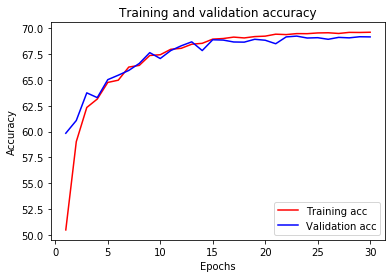

In [15]:
plot_learning(train_accuracies, val_accuracies)

In [16]:
score = test(model, device, testloader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 1.0509, Accuracy: 8889/13000 (68%)

Test loss: 1.0509131072048958
Test accuracy: 68.37692307692308


***Модель с 2 скрытыми полносвязными слоями***<br>
***Функция на выходе - softmax, на промежуточных слоях - гиперболический тангенс tanh***<br>
***Количество нейронов на скрытых слоях: 40, 30; на выходе - 26 классов, согласно числу букв в алфавите***

In [18]:
class Net_2_tanh(nn.Module):
    def __init__(self):
        super(Net_2_tanh, self).__init__()
        self.fc1 = nn.Linear(np.prod(input_size), 40)
        self.fc2 = nn.Linear(40, 30)
        self.fc3 = nn.Linear(30, num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

In [19]:
epochs = 30
device = torch.device("cuda" if use_cuda else "cpu")

model = Net_2_tanh().to(device)
optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    print(epoch)
    train_loss,train_accuracy=train(model, device, trainloader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

1


C:\Users\Tania\Anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train set: Average loss: 0.6160, Accuracy: 28363/65000 44%

Val set: Average loss: 2.2304, Accuracy: 3251/6500 (50%)

2
Train set: Average loss: 0.5280, Accuracy: 33640/65000 52%

Val set: Average loss: 2.0170, Accuracy: 3488/6500 (54%)

3
Train set: Average loss: 0.4910, Accuracy: 35210/65000 54%

Val set: Average loss: 1.9222, Accuracy: 3580/6500 (55%)

4
Train set: Average loss: 0.4706, Accuracy: 36008/65000 55%

Val set: Average loss: 1.8506, Accuracy: 3673/6500 (57%)

5
Train set: Average loss: 0.4569, Accuracy: 36637/65000 56%

Val set: Average loss: 1.8108, Accuracy: 3705/6500 (57%)

6
Train set: Average loss: 0.4477, Accuracy: 37075/65000 57%

Val set: Average loss: 1.7767, Accuracy: 3744/6500 (58%)

7
Train set: Average loss: 0.4408, Accuracy: 37415/65000 58%

Val set: Average loss: 1.7561, Accuracy: 3770/6500 (58%)

8
Train set: Average loss: 0.4359, Accuracy: 37662/65000 58%

Val set: Average loss: 1.7372, Accuracy: 3800/6500 (58%)

9
Train set: Average loss: 0.4320, Accurac

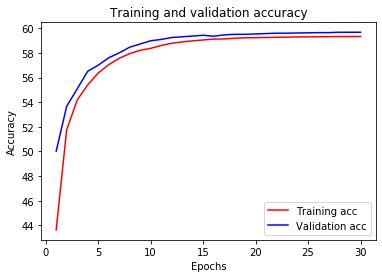

In [20]:
plot_learning(train_accuracies, val_accuracies)

In [21]:
score = test(model, device, testloader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 1.6768, Accuracy: 7653/13000 (59%)

Test loss: 1.676773946413627
Test accuracy: 58.86923076923077


***Модель с 3 скрытыми полносвязными слоями***<br>
***Функция на выходе - softmax, на промежуточных слоях - гиперболический тангенс tanh***<br>
***Количество нейронов на скрытых слоях: 128, 64, 32; на выходе - 26 классов, согласно числу букв в алфавите***

In [62]:
class Net_3_tanh(nn.Module):
    def __init__(self):
        super(Net_3_tanh, self).__init__()
        self.fc1 = nn.Linear(np.prod(input_size), 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = self.fc4(x)
        output = F.log_softmax(x, dim=1)
        return output

In [23]:
epochs = 30
device = torch.device("cuda" if use_cuda else "cpu")

model = Net_3_tanh().to(device)
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(model, device, trainloader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

Train set: Average loss: 0.3235, Accuracy: 41884/65000 64%

Val set: Average loss: 0.8462, Accuracy: 4841/6500 (74%)

Train set: Average loss: 0.1809, Accuracy: 50920/65000 78%

Val set: Average loss: 0.6364, Accuracy: 5243/6500 (81%)

Train set: Average loss: 0.1409, Accuracy: 53930/65000 83%

Val set: Average loss: 0.5356, Accuracy: 5463/6500 (84%)

Train set: Average loss: 0.1251, Accuracy: 55046/65000 85%

Val set: Average loss: 0.4714, Accuracy: 5591/6500 (86%)

Train set: Average loss: 0.1081, Accuracy: 56372/65000 87%

Val set: Average loss: 0.4053, Accuracy: 5723/6500 (88%)

Train set: Average loss: 0.1001, Accuracy: 56987/65000 88%

Val set: Average loss: 0.3939, Accuracy: 5730/6500 (88%)

Train set: Average loss: 0.0899, Accuracy: 57841/65000 89%

Val set: Average loss: 0.3444, Accuracy: 5820/6500 (90%)

Train set: Average loss: 0.0849, Accuracy: 58200/65000 90%

Val set: Average loss: 0.3282, Accuracy: 5854/6500 (90%)

Train set: Average loss: 0.0780, Accuracy: 58806/65000 9

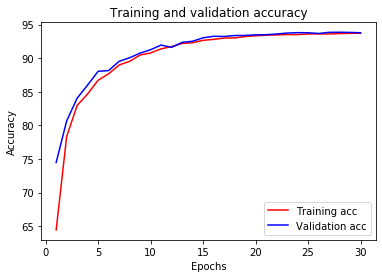

In [24]:
plot_learning(train_accuracies, val_accuracies)

In [25]:
score = test(model, device, testloader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.4203, Accuracy: 11332/13000 (87%)

Test loss: 0.42028712329282786
Test accuracy: 87.16923076923077


***Модель с 3 скрытыми полносвязными слоями***<br>
***Функция на выходе - softmax, на промежуточных слоях - ReLU***<br>
***Количество нейронов на скрытых слоях: 128, 64, 32; на выходе - 26 классов, согласно числу букв в алфавите***

In [26]:
class Net_3_relu(nn.Module):
    def __init__(self):
        super(Net_3_relu, self).__init__()
        self.fc1 = nn.Linear(np.prod(input_size), 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        output = F.log_softmax(x, dim=1)
        return output

In [27]:
epochs = 30
device = torch.device("cuda" if use_cuda else "cpu")

model = Net_3_relu().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    print(epoch)
    train_loss,train_accuracy=train(model, device, trainloader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

1
Train set: Average loss: 0.2916, Accuracy: 41656/65000 64%

Val set: Average loss: 0.8465, Accuracy: 4798/6500 (74%)

2
Train set: Average loss: 0.2053, Accuracy: 48641/65000 75%

Val set: Average loss: 0.7280, Accuracy: 5011/6500 (77%)

3
Train set: Average loss: 0.1744, Accuracy: 50950/65000 78%

Val set: Average loss: 0.6417, Accuracy: 5215/6500 (80%)

4
Train set: Average loss: 0.1660, Accuracy: 51736/65000 80%

Val set: Average loss: 0.6602, Accuracy: 5157/6500 (79%)

5
Train set: Average loss: 0.1494, Accuracy: 53012/65000 82%

Val set: Average loss: 0.6234, Accuracy: 5209/6500 (80%)

6
Train set: Average loss: 0.1454, Accuracy: 53266/65000 82%

Val set: Average loss: 0.5678, Accuracy: 5338/6500 (82%)

7
Train set: Average loss: 0.1336, Accuracy: 54062/65000 83%

Val set: Average loss: 0.5256, Accuracy: 5444/6500 (84%)

8
Train set: Average loss: 0.1307, Accuracy: 54292/65000 84%

Val set: Average loss: 0.5085, Accuracy: 5486/6500 (84%)

9
Train set: Average loss: 0.1224, Accur

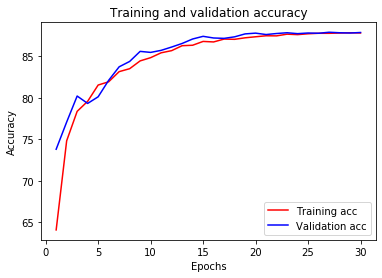

In [28]:
plot_learning(train_accuracies, val_accuracies)

In [29]:
score = test(model, device, testloader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.5180, Accuracy: 10991/13000 (85%)

Test loss: 0.5179562515659043
Test accuracy: 84.54615384615384


***Очевидно, модеи с 3 свёрточными слоями обучаются намного лучше, поэтому здесь тестируется следующая модель:***<br>
***Модель с 3 скрытыми полносвязными слоями***<br>
***Функция на выходе - softmax, на промежуточных слоях - ReLU и tanh (гиперболический тангенс)***<br>
***Количество нейронов на скрытых слоях: 26, 26, 26; на выходе - 26 классов, согласно числу букв в алфавите***

In [33]:
class Net_3_combo(nn.Module):
    def __init__(self):
        super(Net_3_combo, self).__init__()
        self.fc1 = nn.Linear(np.prod(input_size), 26)
        self.fc2 = nn.Linear(26, 26)
        self.fc3 = nn.Linear(26, 26)
        self.fc4 = nn.Linear(26, num_classes)
        

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.tanh(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = self.fc4(x)
        output = F.log_softmax(x, dim=1)
        return output

In [34]:
epochs = 30
device = torch.device("cuda" if use_cuda else "cpu")

model = Net_3_combo().to(device)
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    print(epoch)
    train_loss,train_accuracy=train(model, device, trainloader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

1
Train set: Average loss: 0.4521, Accuracy: 31610/65000 49%

Val set: Average loss: 1.2530, Accuracy: 4145/6500 (64%)

2
Train set: Average loss: 0.2896, Accuracy: 42893/65000 66%

Val set: Average loss: 1.0660, Accuracy: 4462/6500 (69%)

3
Train set: Average loss: 0.2489, Accuracy: 46144/65000 71%

Val set: Average loss: 0.9648, Accuracy: 4622/6500 (71%)

4
Train set: Average loss: 0.2322, Accuracy: 47360/65000 73%

Val set: Average loss: 0.9122, Accuracy: 4766/6500 (73%)

5
Train set: Average loss: 0.2154, Accuracy: 48714/65000 75%

Val set: Average loss: 0.8542, Accuracy: 4866/6500 (75%)

6
Train set: Average loss: 0.2076, Accuracy: 49280/65000 76%

Val set: Average loss: 0.8160, Accuracy: 4959/6500 (76%)

7
Train set: Average loss: 0.1974, Accuracy: 49952/65000 77%

Val set: Average loss: 0.7856, Accuracy: 5004/6500 (77%)

8
Train set: Average loss: 0.1926, Accuracy: 50375/65000 78%

Val set: Average loss: 0.7594, Accuracy: 5046/6500 (78%)

9
Train set: Average loss: 0.1854, Accur

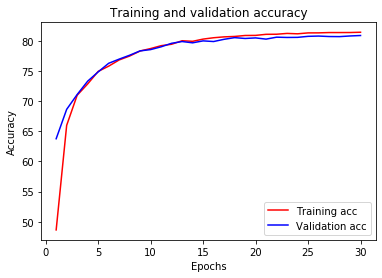

In [35]:
plot_learning(train_accuracies, val_accuracies)

In [36]:
score = test(model, device, testloader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.7523, Accuracy: 10152/13000 (78%)

Test loss: 0.7522915703058243
Test accuracy: 78.0923076923077


***Чтобы каждый раз не обучать модель, сохраним её***

In [223]:
torch.save(best_model, 'best_model')

In [63]:
best_model_saved = torch.load('best_model')
best_model_saved

Net_3_tanh(
  (fc1): Linear(in_features=2352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=26, bias=True)
)

***Проверка работы сохранённой модели на тестовых данных***

In [64]:
score = test(best_model_saved, device, testloader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.4274, Accuracy: 11252/13000 (87%)

Test loss: 0.4273999704214243
Test accuracy: 86.55384615384615


# Вывод по результатам обучения моделей с полносвязными слоями

### Очевидно, хучшим качеством обладает модель с наименьшим количеством полносвязных слоёв - 68.37692307692308 (активация relu) 58.86923076923077 (активация гиперболический тангенс)

### Наилучшее качество модели с полносвязными скрытыми слоями достигается для 3 слоев, модель с использованием активации тангенсом

### При использовании в одной модели разных функций активации и неизменном количестве нейронов на слоях (равном количеству классов, 26 нейронов на каждом слое) качество не улучшается

### №2
***confusion matrix для лучшей модели***

***Лучшая модель - Net_3_tanh(), для неё будут выполнены все следующие задания***

In [29]:
epochs = 30
device = torch.device("cuda" if use_cuda else "cpu")

best_model = Net_3_tanh().to(device)
optimizer = optim.Adamax(best_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(best_model, device, trainloader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(best_model, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

C:\Users\Tania\Anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train set: Average loss: 0.3285, Accuracy: 41470/65000 64%

Val set: Average loss: 0.8319, Accuracy: 4966/6500 (76%)

Train set: Average loss: 0.1837, Accuracy: 50756/65000 78%

Val set: Average loss: 0.6871, Accuracy: 5165/6500 (79%)

Train set: Average loss: 0.1435, Accuracy: 53828/65000 83%

Val set: Average loss: 0.5482, Accuracy: 5411/6500 (83%)

Train set: Average loss: 0.1283, Accuracy: 54790/65000 84%

Val set: Average loss: 0.4911, Accuracy: 5524/6500 (85%)

Train set: Average loss: 0.1110, Accuracy: 56124/65000 86%

Val set: Average loss: 0.4117, Accuracy: 5686/6500 (87%)

Train set: Average loss: 0.1031, Accuracy: 56778/65000 87%

Val set: Average loss: 0.3835, Accuracy: 5732/6500 (88%)

Train set: Average loss: 0.0920, Accuracy: 57605/65000 89%

Val set: Average loss: 0.3574, Accuracy: 5801/6500 (89%)

Train set: Average loss: 0.0873, Accuracy: 58005/65000 89%

Val set: Average loss: 0.3426, Accuracy: 5802/6500 (89%)

Train set: Average loss: 0.0803, Accuracy: 58615/65000 9

In [ ]:
_, predicted = torch.max(outputs, 1)

In [ ]:
# ! pip install scikit-plot

In [1]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

In [ ]:
outputs = net(images)

In [20]:
_, predicted = torch.max(outputs, 1)

In [22]:
images, labels = testdataiter.next()

In [25]:
labels

tensor([23, 11, 23, 17])

In [72]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

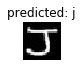

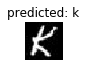

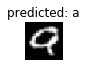

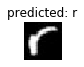

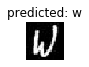

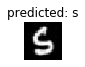

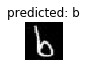

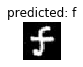

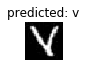

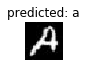

In [73]:
visualize_model(best_model)

In [108]:
trainloader, testloader, classes, dataset_sizes, train_dataset = get_dataset('./images', data_transforms)
traindataiter = iter(trainloader)
testdataiter = iter(testloader)

***Confusion_matrix operations***

In [69]:
import pandas as pd

from sklearn.metrics import confusion_matrix

In [78]:
conf_matrix = torch.zeros(26, 26)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
#         print(len(classes))
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = best_model_saved(inputs)
#         print(len(classes))
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                conf_matrix[t.long(), p.long()] += 1

print(conf_matrix)

tensor([[415.,   7.,   4.,   8.,   2.,   2.,   3.,   9.,   1.,   0.,   1.,   0.,
           3.,   9.,   7.,   2.,  15.,   3.,   0.,   1.,   3.,   0.,   3.,   0.,
           0.,   2.],
        [  5., 443.,   0.,  12.,   4.,   2.,   5.,   5.,   0.,   1.,   0.,   2.,
           0.,   2.,   5.,   0.,   2.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,
           1.,   9.],
        [  1.,   1., 449.,   0.,  31.,   0.,   2.,   0.,   0.,   0.,   1.,   4.,
           0.,   0.,   7.,   0.,   0.,   2.,   0.,   1.,   1.,   0.,   0.,   0.,
           0.,   0.],
        [  8.,   5.,   0., 443.,   0.,   1.,   1.,   2.,   0.,   4.,   1.,   4.,
           1.,   2.,  14.,   3.,   1.,   0.,   1.,   1.,   4.,   1.,   0.,   0.,
           0.,   3.],
        [  1.,   5.,  23.,   0., 448.,   3.,   2.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   2.,   6.,   3.,   0.,   1.,   0.,   0.,   0.,
           0.,   6.],
        [  1.,   0.,   0.,   1.,   2., 442.,   7.,   0.,   1.,   1.,   0.,   0.,

In [67]:
# confusion_matrix = torch.zeros(len(classes), len(classes))
# with torch.no_grad():
#     for i, (inputs, classes) in enumerate(testloader):
# #         print(len(classes))
#         inputs = inputs.to(device)
#         classes = classes.to(device)
#         outputs = best_model(inputs)
# #         print(len(classes))
#         _, preds = torch.max(outputs, 1)
#         for t, p in zip(classes.view(-1), preds.view(-1)):
#                 confusion_matrix[t.long(), p.long()] += 1

# print(confusion_matrix)

In [81]:
# conf_matrix.numpy()

In [80]:
cm = conf_matrix.numpy()
pd.DataFrame(cm).astype(int)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,415,7,4,8,2,2,3,9,1,0,...,15,3,0,1,3,0,3,0,0,2
1,5,443,0,12,4,2,5,5,0,1,...,2,0,1,0,0,0,1,0,1,9
2,1,1,449,0,31,0,2,0,0,0,...,0,2,0,1,1,0,0,0,0,0
3,8,5,0,443,0,1,1,2,0,4,...,1,0,1,1,4,1,0,0,0,3
4,1,5,23,0,448,3,2,0,0,0,...,2,6,3,0,1,0,0,0,0,6
5,1,0,0,1,2,442,7,0,1,1,...,5,3,2,13,0,0,0,0,1,0
6,12,10,0,5,2,4,342,0,0,3,...,93,1,16,0,0,0,0,0,6,1
7,6,11,0,2,0,0,0,434,0,0,...,0,2,0,2,2,0,0,2,0,1
8,0,0,0,0,0,2,0,0,353,11,...,1,2,1,4,1,0,0,3,3,11
9,1,0,0,6,0,0,6,1,12,445,...,2,0,9,4,0,3,1,0,3,1


### Из confusion_matrix видно, что в целом, модель обучилась достаточно хорошо и равномерно, в среднем точность детекции букв не сильно различается, т.к. на каждую букву приходится 500 изображений, а на главной диагонали матрицы стоят значения очень близкие к 500 ~>450, за некоторыми исключениями

In [162]:
# cm[0]

In [163]:
# sorted(cm[0],reverse=True)[1: 11]

In [164]:
# np.argsort(cm[0])[len(cm)-2:len(cm)-12:-1]

In [100]:
accuracies = (conf_matrix.diag()/conf_matrix.sum(1)).numpy()
pd.DataFrame(accuracies)

,0
0,0.830
1,0.886
2,0.898
3,0.886
4,0.896
5,0.884
6,0.684
7,0.868
8,0.706
9,0.890


In [107]:
args_sorted = np.argsort(accuracies)
accs_sorted = sorted(accuracies)

In [111]:
args_sorted[-1]

14

In [109]:
accs_sorted[-1]

0.942

In [116]:
import string

classes = list(string.ascii_uppercase)
# classes

In [117]:
print(f'Буква с лучшей детекцией: {classes[args_sorted[-1]]}  accuracy: {accs_sorted[-1]}')
print(f'Буква с худшей детекцией: {classes[args_sorted[0]]}  accuracy: {accs_sorted[0]}')

Буква с лучшей детекцией: O  accuracy: 0.9419999718666077
Буква с худшей детекцией: G  accuracy: 0.6840000152587891


### №3
***10 пар сложно различимых между собой букв***

In [159]:
worst = []
worst_idx = []

for i in range(len(cm)):
#     tmp = sorted(cm[0],reverse=True)[1: 11]
#     tmp_idx = np.argsort(cm[0])[len(cm)-2:len(cm)-12:-1] # сортировка, находим индексы первых 10 макс-но ошибающихся (по уб)
    tmp = sorted(cm[i],reverse=True)[1]
    tmp_idx = np.argsort(cm[i])[len(cm)-2] # индекс буквы, с которой максимально путается
    worst.append(tmp)
    worst_idx.append(tmp_idx)  

In [160]:
zipped = zip(worst, worst_idx, range(26))
zipped = sorted(zipped, key = lambda t: t[1], reverse=True)

In [161]:
# sorted(zip(worst, worst_idx), key=worst)
# for i in zipped:
#     print(*i)
pairs_10 = zipped[:10]
for i in pairs_10:
    print(*i)

10.0 24 23
18.0 23 10
13.0 21 20
22.0 21 24
20.0 20 21
12.0 17 19
15.0 16 0
93.0 16 6
21.0 15 5
14.0 14 3


In [166]:
for let in pairs_10:
    print(f'{classes[let[2]]}  --  {classes[let[1]]}')

x  --  y
k  --  x
u  --  v
y  --  v
v  --  u
t  --  r
a  --  q
g  --  q
f  --  p
d  --  o


***Визуально, буквы в данных парах похожи между собой, очевидно, в различных рукописных сэмплах их действительно бывает сложно отличать друг от друга (данное предположение основывается на геометрическом представлении этих букв)***

In [168]:
# print("Classification report for classifier %s:\n%s\n"
#       % (model, metrics.classification_report(y_test, model.predict_classes(test_set))))

### №4
***Точность детекции буквы 'V' и буквы, плохо отличимые от неё***

In [169]:
# порядковый номер V - 22, т.к. отсчёт с 0 - 21
classes[21]

'v'

***Из confusion_matrix видно, что точность определения буквы V = 451, т.к. картинок с этой буквой 500, accuracy для неё = 451/500 = 0.902, это хороший показатель***

In [185]:
np.argsort(cm[21])

array([25,  1,  2,  4,  5, 18, 16,  8, 15, 11, 19, 14,  0, 10,  9,  6,  3,
       12, 13,  7, 23, 22, 17, 24, 20, 21], dtype=int64)

In [186]:
cm[21]

array([  1.,   0.,   0.,   1.,   0.,   0.,   1.,   2.,   0.,   1.,   1.,
         0.,   1.,   2.,   1.,   0.,   0.,   4.,   0.,   1.,  20., 451.,
         3.,   2.,   8.,   0.], dtype=float32)

***Ниже - 5 букв, которые с большей частотой путаются с буквой V:***<br>
***U, Y, R, W, H, N***<br>
***Можно предположить, что именно эти буквы плохо отличимы от V, из-за их геометрического представления, визуально они очень похожи, и могут быть написаны схожим образом***

In [193]:
# letters = sorted(cm[21],reverse=True)
# idx = np.argsort(cm[21]) # индекс буквы, с которой максимально путается НЕ РЕВЕРСНУЛА


letters = cm[21]
idx = range(26) # индекс буквы, с которой максимально путается НЕ РЕВЕРСНУЛА

pairs = zip(letters, idx)
pairs = sorted(pairs, key = lambda t: t[0], reverse=True)
j = 0
for i in pairs:
    if j == 0:
        pass
    else:
        print(classes[i[1]])
        print(*i)
    j+=1
    if j > 6:
        break

u
20.0 20
y
8.0 24
r
4.0 17
w
3.0 22
h
2.0 7
n
2.0 13


### Задание 2
  
1. Модели нейронной сети с 1-м, 2-мя и 3-мя сверточными слоями.  
Исследуются различные значения параметров сверток и числа фильтров на каждом слое.

2. Изменение качества модели при увеличении размера батча при использовании BatchNorm и GroupNorm.    

### №1
***Обучение нейронной сети со свёрточными слоями***<br>
***За основу для обучение сети со сверточными слоями взята лучшая модель с 3 полносвязными слоями Net_3_tanh***

In [11]:
batch_size = 5
use_cuda = torch.cuda.is_available()
print(use_cuda)

torch.manual_seed(17)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))

train_set, val_set = torch.utils.data.random_split(train_dataset, [num_train-split, split])
print(len(train_set), len(val_set))

val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size, shuffle=False, **kwargs)

C:\Users\Tania\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


False
58500 6500


***Обучение нейронной сети с 1 свёрточным слоем***

In [18]:
class ConvNet_1(nn.Module):
    def __init__(self):
        super(ConvNet_1, self).__init__()
        self.layer1 = nn.Sequential( nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(14400, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 26)

    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = F.tanh(self.fc1(out))
        out = F.tanh(self.fc2(out))
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)
        return out

In [68]:
epochs = 10
device = torch.device("cuda" if use_cuda else "cpu")

model_1 = ConvNet_1().to(device)
optimizer = optim.Adamax(model_1.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(model_1, device, trainloader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model_1, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

Train set: Average loss: 0.0276, Accuracy: 53199/65000 82%

Val set: Average loss: 0.3059, Accuracy: 5857/6500 (90%)

Train set: Average loss: 0.0131, Accuracy: 58422/65000 90%

Val set: Average loss: 0.2401, Accuracy: 6002/6500 (92%)

Train set: Average loss: 0.0101, Accuracy: 59780/65000 92%

Val set: Average loss: 0.1854, Accuracy: 6134/6500 (94%)

Train set: Average loss: 0.0092, Accuracy: 60254/65000 93%

Val set: Average loss: 0.1704, Accuracy: 6154/6500 (95%)

Train set: Average loss: 0.0078, Accuracy: 60930/65000 94%

Val set: Average loss: 0.1383, Accuracy: 6221/6500 (96%)

Train set: Average loss: 0.0073, Accuracy: 61196/65000 94%

Val set: Average loss: 0.1350, Accuracy: 6231/6500 (96%)

Train set: Average loss: 0.0064, Accuracy: 61671/65000 95%

Val set: Average loss: 0.1208, Accuracy: 6267/6500 (96%)

Train set: Average loss: 0.0061, Accuracy: 61774/65000 95%

Val set: Average loss: 0.1135, Accuracy: 6281/6500 (97%)

Train set: Average loss: 0.0054, Accuracy: 62211/65000 9

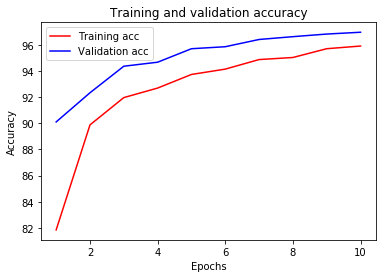

In [69]:
plot_learning(train_accuracies, val_accuracies)

In [70]:
score = test(model_1, device, testloader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.1918, Accuracy: 12156/13000 (94%)

Test loss: 0.19178891357321007
Test accuracy: 93.50769230769231


***Обучение нейронной сети с 2 свёрточными слоями***

In [21]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential( nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=5, stride=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(64*5*5, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 26)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = F.tanh(self.fc1(out))
        out = F.tanh(self.fc2(out))
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)
        return out

In [57]:
epochs = 30
device = torch.device("cuda" if use_cuda else "cpu")

model = ConvNet().to(device)
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(model, device, trainloader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

Train set: Average loss: 0.0288, Accuracy: 52203/65000 80%

Val set: Average loss: 0.2856, Accuracy: 5909/6500 (91%)

Train set: Average loss: 0.0138, Accuracy: 58047/65000 89%

Val set: Average loss: 0.2259, Accuracy: 6041/6500 (93%)

Train set: Average loss: 0.0111, Accuracy: 59298/65000 91%

Val set: Average loss: 0.1854, Accuracy: 6100/6500 (94%)

Train set: Average loss: 0.0101, Accuracy: 59724/65000 92%

Val set: Average loss: 0.1758, Accuracy: 6124/6500 (94%)

Train set: Average loss: 0.0091, Accuracy: 60261/65000 93%

Val set: Average loss: 0.1585, Accuracy: 6147/6500 (95%)

Train set: Average loss: 0.0086, Accuracy: 60415/65000 93%

Val set: Average loss: 0.1517, Accuracy: 6178/6500 (95%)

Train set: Average loss: 0.0081, Accuracy: 60704/65000 93%

Val set: Average loss: 0.1442, Accuracy: 6200/6500 (95%)

Train set: Average loss: 0.0078, Accuracy: 60894/65000 94%

Val set: Average loss: 0.1391, Accuracy: 6195/6500 (95%)

Train set: Average loss: 0.0074, Accuracy: 61065/65000 9

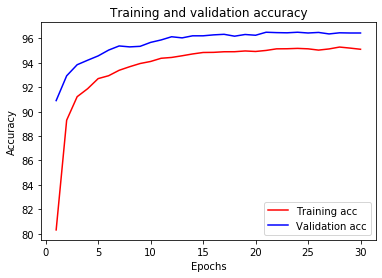

In [58]:
plot_learning(train_accuracies, val_accuracies)

In [59]:
score = test(model, device, testloader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.1501, Accuracy: 12321/13000 (95%)

Test loss: 0.15013994351487894
Test accuracy: 94.77692307692308


***Сохранение лучшей модели со свёрточными слоями***

In [122]:
# torch.save(model, 'best_conv_model')
best_conv_model_saved = torch.load('best_conv_model')
best_conv_model_saved

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=26, bias=True)
)

***Обучение нейронной сети с 3 свёрточными слоями***

In [18]:
class ConvNet_3(nn.Module):
    def __init__(self):
        super(ConvNet_3, self).__init__()
        self.layer1 = nn.Sequential( nn.Conv2d(3, 16, kernel_size=10, stride=2, padding=4),
            nn.ReLU(), nn.AvgPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential( nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=4),
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=4),
            nn.ReLU(), nn.AvgPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(1024, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 26)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = F.tanh(self.fc1(out))
        out = F.tanh(self.fc2(out))
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)
        return out

In [19]:
epochs = 30
device = torch.device("cuda" if use_cuda else "cpu")

model_3 = ConvNet_3().to(device)
optimizer = optim.Adamax(model_3.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(model_3, device, trainloader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model_3, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

C:\Users\Tania\Anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train set: Average loss: 0.0501, Accuracy: 41499/65000 64%

Val set: Average loss: 0.5097, Accuracy: 5519/6500 (85%)

Train set: Average loss: 0.0194, Accuracy: 55462/65000 85%

Val set: Average loss: 0.3458, Accuracy: 5798/6500 (89%)

Train set: Average loss: 0.0147, Accuracy: 57697/65000 89%

Val set: Average loss: 0.2883, Accuracy: 5889/6500 (91%)

Train set: Average loss: 0.0132, Accuracy: 58358/65000 90%

Val set: Average loss: 0.2736, Accuracy: 5945/6500 (91%)

Train set: Average loss: 0.0117, Accuracy: 59076/65000 91%

Val set: Average loss: 0.2541, Accuracy: 5992/6500 (92%)

Train set: Average loss: 0.0112, Accuracy: 59286/65000 91%

Val set: Average loss: 0.2391, Accuracy: 6025/6500 (93%)

Train set: Average loss: 0.0105, Accuracy: 59629/65000 92%

Val set: Average loss: 0.2210, Accuracy: 6030/6500 (93%)

Train set: Average loss: 0.0102, Accuracy: 59775/65000 92%

Val set: Average loss: 0.2176, Accuracy: 6042/6500 (93%)

Train set: Average loss: 0.0097, Accuracy: 60064/65000 9

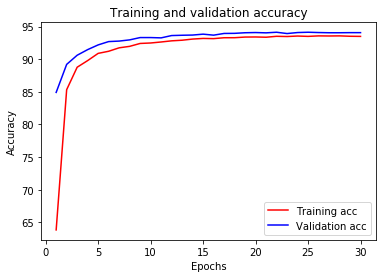

In [20]:
plot_learning(train_accuracies, val_accuracies)

In [22]:
score = test(model_3, device, testloader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.1984, Accuracy: 12138/13000 (93%)

Test loss: 0.19843898669572976
Test accuracy: 93.36923076923077


***Обучение нейронной сети с 3 свёрточными слоями c бОльшим размером фильтров***

In [28]:
class ConvNet_32(nn.Module):
    def __init__(self):
        super(ConvNet_32, self).__init__()
        self.layer1 = nn.Sequential( nn.Conv2d(3, 32, kernel_size=10, stride=2, padding=4),
            nn.Tanh(), nn.AvgPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=4),
            nn.ReLU(), nn.AvgPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential( nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=4),
            nn.Tanh(), nn.AvgPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(1152, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 26)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = F.tanh(self.fc1(out))
        out = F.tanh(self.fc2(out))
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)
        return out

In [29]:
epochs = 20
device = torch.device("cuda" if use_cuda else "cpu")

model_32 = ConvNet_32().to(device)
optimizer = optim.Adamax(model_32.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(model_32, device, trainloader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model_32, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

Train set: Average loss: 0.0425, Accuracy: 45631/65000 70%

Val set: Average loss: 0.4925, Accuracy: 5488/6500 (84%)

Train set: Average loss: 0.0182, Accuracy: 56106/65000 86%

Val set: Average loss: 0.3348, Accuracy: 5846/6500 (90%)

Train set: Average loss: 0.0139, Accuracy: 58192/65000 90%

Val set: Average loss: 0.3076, Accuracy: 5874/6500 (90%)

Train set: Average loss: 0.0125, Accuracy: 58694/65000 90%

Val set: Average loss: 0.2915, Accuracy: 5922/6500 (91%)

Train set: Average loss: 0.0110, Accuracy: 59497/65000 92%

Val set: Average loss: 0.2618, Accuracy: 5961/6500 (92%)

Train set: Average loss: 0.0105, Accuracy: 59670/65000 92%

Val set: Average loss: 0.2445, Accuracy: 6018/6500 (93%)

Train set: Average loss: 0.0097, Accuracy: 60085/65000 92%

Val set: Average loss: 0.2278, Accuracy: 6036/6500 (93%)

Train set: Average loss: 0.0094, Accuracy: 60237/65000 93%

Val set: Average loss: 0.2141, Accuracy: 6068/6500 (93%)

Train set: Average loss: 0.0088, Accuracy: 60558/65000 9

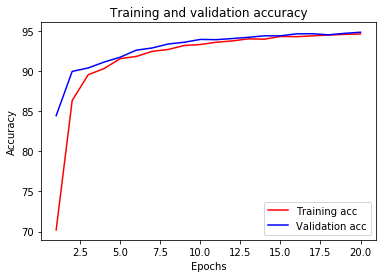

In [30]:
plot_learning(train_accuracies, val_accuracies)

In [32]:
score = test(model_32, device, testloader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.2098, Accuracy: 12087/13000 (93%)

Test loss: 0.2097567612322477
Test accuracy: 92.97692307692307


### В среднем, значения accuracy для рассмотренных моделей различаются не более, чем на 1%, для тестовой выборки, значение метрики ~0.93-0.95 является хорошим показателем обучения модели

### №2
***Сравнение качества модели при увеличении размера батча при использовании BatchNorm и GroupNorm***<br>
**Для размера 128**

**BatchNorm**

In [35]:
trainloader, testloader, classes, dataset_sizes, train_dataset = get_dataset('./images', data_transforms, 128)
traindataiter = iter(trainloader)
testdataiter = iter(testloader)

In [36]:
#128
batch_size = 128
use_cuda = torch.cuda.is_available()
print(use_cuda)

torch.manual_seed(17)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))

train_set, val_set = torch.utils.data.random_split(train_dataset, [num_train-split, split])
print(len(train_set), len(val_set))

val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size, shuffle=False, **kwargs)

False
58500 6500


In [38]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential( nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=3),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=5, stride=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(64*5*5, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 26)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = F.tanh(self.fc1(out))
        out = F.tanh(self.fc2(out))
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)
        return out

In [39]:
epochs = 30
device = torch.device("cuda" if use_cuda else "cpu")

model = ConvNet().to(device)
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(model, device, trainloader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

Train set: Average loss: 0.0059, Accuracy: 53033/65000 82%

Val set: Average loss: 0.3008, Accuracy: 5936/6500 (91%)

Train set: Average loss: 0.0025, Accuracy: 58626/65000 90%

Val set: Average loss: 0.2183, Accuracy: 6074/6500 (93%)

Train set: Average loss: 0.0019, Accuracy: 59915/65000 92%

Val set: Average loss: 0.1912, Accuracy: 6110/6500 (94%)

Train set: Average loss: 0.0018, Accuracy: 60236/65000 93%

Val set: Average loss: 0.1695, Accuracy: 6167/6500 (95%)

Train set: Average loss: 0.0016, Accuracy: 60742/65000 93%

Val set: Average loss: 0.1572, Accuracy: 6185/6500 (95%)

Train set: Average loss: 0.0015, Accuracy: 60923/65000 94%

Val set: Average loss: 0.1558, Accuracy: 6184/6500 (95%)

Train set: Average loss: 0.0014, Accuracy: 61167/65000 94%

Val set: Average loss: 0.1384, Accuracy: 6220/6500 (96%)

Train set: Average loss: 0.0013, Accuracy: 61299/65000 94%

Val set: Average loss: 0.1421, Accuracy: 6202/6500 (95%)

Train set: Average loss: 0.0013, Accuracy: 61477/65000 9

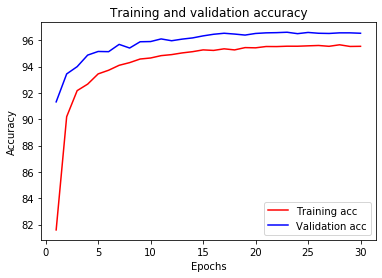

In [41]:
plot_learning(train_accuracies, val_accuracies)

***Результат на тестовой выборке***

In [40]:
score = test(model, device, testloader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.1513, Accuracy: 12340/13000 (95%)

Test loss: 0.15130543220960177
Test accuracy: 94.92307692307692


**GroupNorm**

In [46]:
class ConvNet_gn(nn.Module):
    def __init__(self):
        super(ConvNet_gn, self).__init__()
        self.layer1 = nn.Sequential( nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=3),
                                    nn.GroupNorm(num_groups=8, num_channels=32),
                                    nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=5, stride=1),
                                    nn.GroupNorm(num_groups=16, num_channels=64),
                                    nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(64*5*5, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 26)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = F.tanh(self.fc1(out))
        out = F.tanh(self.fc2(out))
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)
        return out

In [47]:
epochs = 20
device = torch.device("cuda" if use_cuda else "cpu")

model_gn = ConvNet_gn().to(device)
optimizer = optim.Adamax(model_gn.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(model_gn, device, trainloader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model_gn, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

Train set: Average loss: 0.0062, Accuracy: 51934/65000 80%

Val set: Average loss: 0.3191, Accuracy: 5906/6500 (91%)

Train set: Average loss: 0.0026, Accuracy: 58329/65000 90%

Val set: Average loss: 0.2373, Accuracy: 6009/6500 (92%)

Train set: Average loss: 0.0020, Accuracy: 59638/65000 92%

Val set: Average loss: 0.1972, Accuracy: 6101/6500 (94%)

Train set: Average loss: 0.0018, Accuracy: 60051/65000 92%

Val set: Average loss: 0.1778, Accuracy: 6135/6500 (94%)

Train set: Average loss: 0.0016, Accuracy: 60527/65000 93%

Val set: Average loss: 0.1651, Accuracy: 6173/6500 (95%)

Train set: Average loss: 0.0015, Accuracy: 60748/65000 93%

Val set: Average loss: 0.1584, Accuracy: 6156/6500 (95%)

Train set: Average loss: 0.0014, Accuracy: 61033/65000 94%

Val set: Average loss: 0.1589, Accuracy: 6150/6500 (95%)

Train set: Average loss: 0.0014, Accuracy: 61165/65000 94%

Val set: Average loss: 0.1451, Accuracy: 6188/6500 (95%)

Train set: Average loss: 0.0013, Accuracy: 61310/65000 9

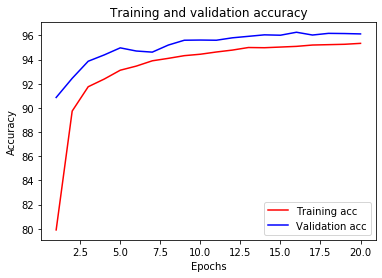

In [49]:
plot_learning(train_accuracies, val_accuracies)

***Результат на тестовой выборке***

In [48]:
score = test(model_gn, device, testloader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.1540, Accuracy: 12332/13000 (95%)

Test loss: 0.15396936658712534
Test accuracy: 94.86153846153846


**Для размера 256**<br>
***BatchNorm***

In [50]:
trainloader, testloader, classes, dataset_sizes, train_dataset = get_dataset('./images', data_transforms, 256)
traindataiter = iter(trainloader)
testdataiter = iter(testloader)

In [51]:
batch_size = 256
use_cuda = torch.cuda.is_available()
print(use_cuda)

torch.manual_seed(17)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))

train_set, val_set = torch.utils.data.random_split(train_dataset, [num_train-split, split])
print(len(train_set), len(val_set))

val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size, shuffle=False, **kwargs)

False
58500 6500


In [52]:
epochs = 30
device = torch.device("cuda" if use_cuda else "cpu")

model = ConvNet().to(device)
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(model, device, trainloader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

Train set: Average loss: 0.0035, Accuracy: 51276/65000 79%

Val set: Average loss: 0.3658, Accuracy: 5877/6500 (90%)

Train set: Average loss: 0.0014, Accuracy: 58173/65000 89%

Val set: Average loss: 0.2600, Accuracy: 5992/6500 (92%)

Train set: Average loss: 0.0011, Accuracy: 59498/65000 92%

Val set: Average loss: 0.2056, Accuracy: 6104/6500 (94%)

Train set: Average loss: 0.0010, Accuracy: 60093/65000 92%

Val set: Average loss: 0.1848, Accuracy: 6136/6500 (94%)

Train set: Average loss: 0.0009, Accuracy: 60496/65000 93%

Val set: Average loss: 0.1693, Accuracy: 6161/6500 (95%)

Train set: Average loss: 0.0008, Accuracy: 60656/65000 93%

Val set: Average loss: 0.1579, Accuracy: 6189/6500 (95%)

Train set: Average loss: 0.0007, Accuracy: 61028/65000 94%

Val set: Average loss: 0.1541, Accuracy: 6185/6500 (95%)

Train set: Average loss: 0.0007, Accuracy: 61061/65000 94%

Val set: Average loss: 0.1488, Accuracy: 6194/6500 (95%)

Train set: Average loss: 0.0007, Accuracy: 61277/65000 9

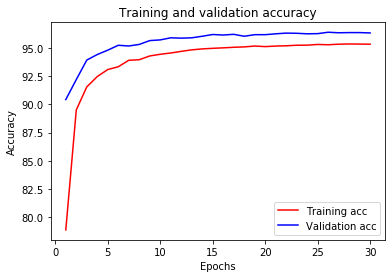

In [53]:
plot_learning(train_accuracies, val_accuracies)

***Результат на тестовой выборке***

In [54]:
score = test(model, device, testloader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.1571, Accuracy: 12312/13000 (95%)

Test loss: 0.15712390151390662
Test accuracy: 94.70769230769231


***GroupNorm + LayerNorm после Fully Connected слоёв***

In [59]:
class ConvNet_gn(nn.Module):
    def __init__(self):
        super(ConvNet_gn, self).__init__()
        self.layer1 = nn.Sequential( nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=3),
                                    nn.GroupNorm(num_groups=8, num_channels=32),
                                    nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=5, stride=1),
                                    nn.GroupNorm(num_groups=16, num_channels=64),
                                    nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(64*5*5, 1000)
        self.bn1 = nn.LayerNorm(1000)
        self.fc2 = nn.Linear(1000, 100)
        self.bn2 = nn.LayerNorm(100)
        self.fc3 = nn.Linear(100, 26)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = F.tanh(self.bn1(self.fc1(out)))
        out = F.tanh(self.bn2(self.fc2(out)))
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)
        return out

In [60]:
epochs = 30
device = torch.device("cuda" if use_cuda else "cpu")

model_gn = ConvNet_gn().to(device)
optimizer = optim.Adamax(model_gn.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = StepLR(optimizer, step_size=2, gamma=0.7)
train_accuracies,val_accuracies=[],[]
for epoch in range(1, epochs + 1):
    train_loss,train_accuracy=train(model_gn, device, trainloader, optimizer, epoch)
    train_accuracies.append(train_accuracy)
    val_loss,val_accuracy=test(model_gn, device, val_loader)
    val_accuracies.append(val_accuracy)
    scheduler.step()

Train set: Average loss: 0.0042, Accuracy: 49444/65000 76%

Val set: Average loss: 0.4287, Accuracy: 5814/6500 (89%)

Train set: Average loss: 0.0017, Accuracy: 57292/65000 88%

Val set: Average loss: 0.2789, Accuracy: 5996/6500 (92%)

Train set: Average loss: 0.0013, Accuracy: 58830/65000 91%

Val set: Average loss: 0.2325, Accuracy: 6054/6500 (93%)

Train set: Average loss: 0.0011, Accuracy: 59364/65000 91%

Val set: Average loss: 0.2126, Accuracy: 6077/6500 (93%)

Train set: Average loss: 0.0010, Accuracy: 59892/65000 92%

Val set: Average loss: 0.1908, Accuracy: 6111/6500 (94%)

Train set: Average loss: 0.0009, Accuracy: 60117/65000 92%

Val set: Average loss: 0.1747, Accuracy: 6137/6500 (94%)

Train set: Average loss: 0.0009, Accuracy: 60424/65000 93%

Val set: Average loss: 0.1695, Accuracy: 6143/6500 (95%)

Train set: Average loss: 0.0008, Accuracy: 60569/65000 93%

Val set: Average loss: 0.1597, Accuracy: 6162/6500 (95%)

Train set: Average loss: 0.0008, Accuracy: 60840/65000 9

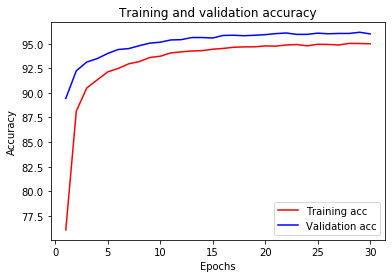

In [118]:
plot_learning(train_accuracies, val_accuracies)

***Результат на тестовой выборке***

In [119]:
score = test(model_gn, device, testloader)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Val set: Average loss: 0.1588, Accuracy: 12291/13000 (95%)

Test loss: 0.15884529363192046
Test accuracy: 94.54615384615384


***Лучшее значение accuracy при обучении было достигнуто при применении BatchNorm, но при этом качество улучшилось всего на несколько десятых процента***<br>
***При увеличении batch_size улучшений при применении следующих нормализаций не обнаружено, качество на тестовых данных снизилось, но опять же не более, чем на несколько десятых процента***

* ***accuracy >= 0.85 достигается даже без использования свёрточных слоёв - на полносвязной сети с 3 скрытыми слоями и функциями активации ReLU - 85%, tanh - 87% (в коде такие классы названы Net_3_relu(), Net_3_tanh(), соответсвенно)***

* ***accuracy ~0.95 достигается на тесте для следующей модели со свёрточными слоями (ConvNet), а также для всех моделей со сверточными слоями и/или использованием нормализации***<br>
<p>
ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=26, bias=True)
)
</p>

***В среднем, в исследованных способов реализации, для моделей со свёрточными слоями достигается accuracy >0.93***

## Дополнительные исследования

***Тестирование загрузки изображений, инверсии цвета, приведения разрешения***<br>
***Image preprocessing***

In [23]:
pic = plt.imread('images/my_test/a/a.jpg')
print(pic.shape)

(640, 640, 3)


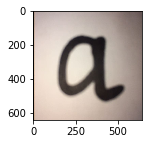

In [24]:
plt.figure(figsize=(2,2))
plt.imshow(pic)
plt.show()

In [205]:
# ! pip install opencv-python

In [25]:
import cv2 #open cv

In [26]:
img = cv2.imread("images/my_test/y/y.jpg")
print(type(img))

<class 'numpy.ndarray'>


In [27]:
img = cv2.resize(img, (28 , 28))
pic = cv2.resize(pic, (28 , 28))

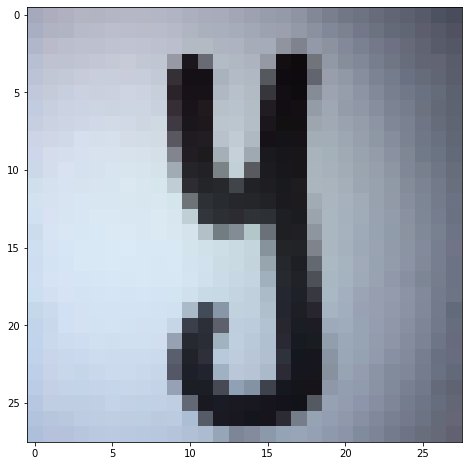

In [28]:
plt.figure(figsize = (8, 8))
plt.imshow(img)

In [29]:
def inverte_color(imagem, name):
    imagem = (255-imagem)
    cv2.imwrite(name, imagem)

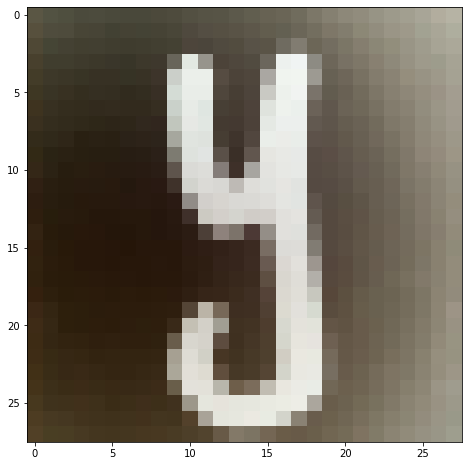

In [30]:
img = cv2.bitwise_not(img)
plt.figure(figsize = (8, 8))
plt.imshow(img)

In [31]:
ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

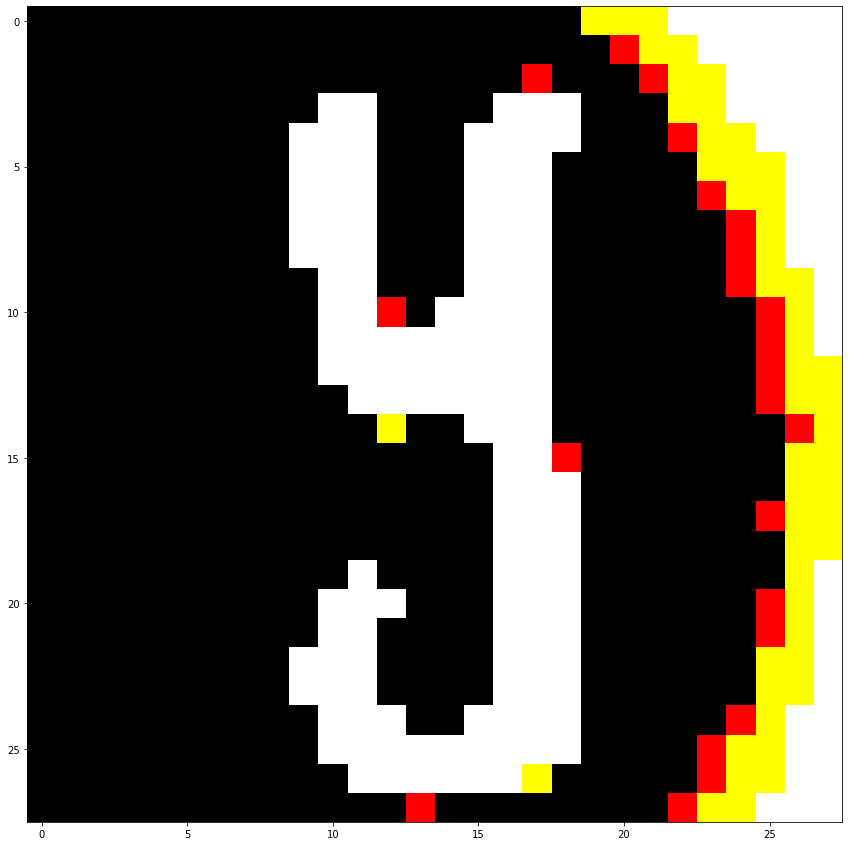

In [32]:
plt.figure(figsize = (15, 15)) 
plt.imshow(thresh1)

***Загрузка лучшей модели, предварительно необходимо запустить код с описанием класса ConvNet***

In [22]:
best_conv_model_saved = torch.load('best_conv_model')
best_conv_model_saved

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=26, bias=True)
)

In [35]:
img = torch.from_numpy(np.asarray(thresh1))